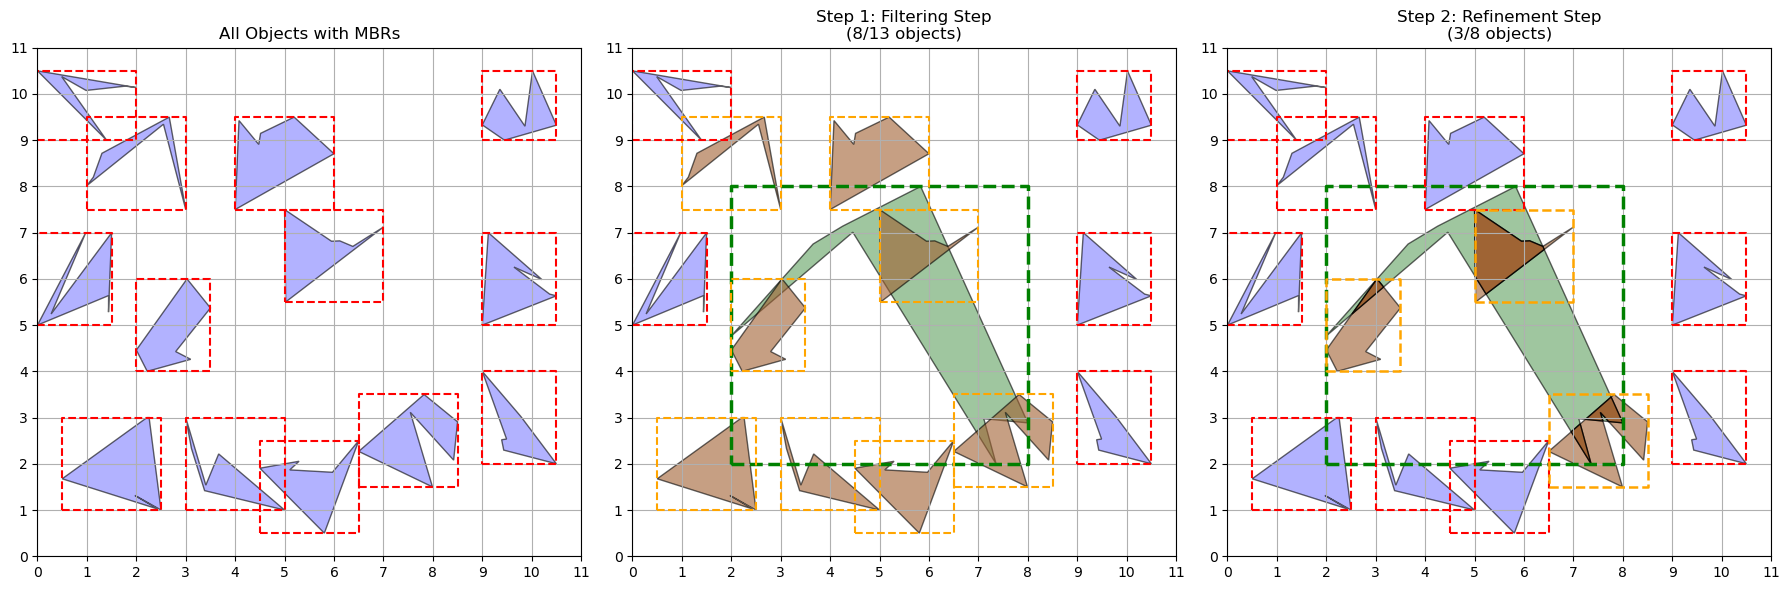

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, box, MultiPolygon
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def generate_random_polygon(bounds, num_points, seed=None):
    """
    Generates a random polygon within specified bounds.

    Parameters:
        bounds (tuple): A tuple (min_x, min_y, max_x, max_y) defining the bounding box.
        num_points (int): Number of points for the polygon.
        seed (int): Optional seed for reproducibility.

    Returns:
        Polygon: A Shapely Polygon object.
    """
    if seed is not None:
        random.seed(seed)
        
    min_x, min_y, max_x, max_y = bounds

    while True:
        points = [(random.uniform(min_x, max_x), random.uniform(min_y, max_y)) for _ in range(num_points)]
        # Modify points to align with MBR edges
        i, j = random.sample(range(num_points), 2)
        points[i] = (min_x, points[i][1])
        points[j] = (max_x, points[j][1])
        i, j = random.sample(range(num_points), 2)
        points[i] = (points[i][0], min_y)
        points[j] = (points[j][0], max_y)

        polygon = Polygon(points)
        # Check if the polygon is valid
        if polygon.is_valid:
            break

    return polygon

def polygon_to_patch(geometry, color='#8080FF', alpha=0.6):
    """
    Convert a shapely geometry (Polygon or MultiPolygon) to a list of matplotlib patches.
    """
    patches = []
    
    # Handle both Polygon and MultiPolygon geometries
    if isinstance(geometry, Polygon):
        x, y = geometry.exterior.xy
        patches.append(mpatches.Polygon(np.column_stack((x, y)), 
                                      facecolor=color, alpha=alpha, edgecolor='black', linewidth=1))
    elif isinstance(geometry, MultiPolygon):
        for poly in geometry.geoms:
            x, y = poly.exterior.xy
            patches.append(mpatches.Polygon(np.column_stack((x, y)), 
                                          facecolor=color, alpha=alpha, edgecolor='black', linewidth=1))
    
    return patches

def plot_polygon_with_mbr(ax, polygon, mbr_color='red', poly_color='#8080FF', alpha=0.6, linewidth=1.5):
    """Plot a polygon with its MBR."""
    # Plot the polygon
    patches = polygon_to_patch(polygon, color=poly_color, alpha=alpha)
    for patch in patches:
        ax.add_patch(patch)
    
    # Get the MBR
    minx, miny, maxx, maxy = polygon.bounds
    # Plot the MBR as dashed rectangle
    ax.plot([minx, maxx, maxx, minx, minx], [miny, miny, maxy, maxy, miny], 
            color=mbr_color, linestyle='--', linewidth=linewidth)

def main():
    # Set random seed for reproducibility
    random.seed(4)
    
    # Parameters
    grid_size = 11  # Changed from 12 to 11 as requested
    query_bounds = (2, 2, 8, 8)  # Region for query polygon - larger central area
    
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define specific locations for polygons to match the reference image
    # Add more polygons, including some that are clearly outside query region
    poly_locations = [
        (1, 7.5, 3, 9.5),     # Top left
        (4, 7.5, 6, 9.5),     # Top right
        (5, 5.5, 7, 7.5),     # Middle right
        (2, 4, 3.5, 6),       # Middle left
        (4.5, 0.5, 6.5, 2.5), # Bottom middle-right
        (0.5, 1, 2.5, 3),     # Bottom left
        (3, 1, 5, 3),         # Bottom middle
        (6.5, 1.5, 8.5, 3.5), # Bottom right
        # Additional polygons that won't be selected
        (9, 9, 10.5, 10.5),   # Top right corner - outside
        (9, 2, 10.5, 4),      # Right side - outside
        (9, 5, 10.5, 7),      # Middle right - outside
        (0, 9, 2, 10.5),      # Top left corner - outside
        (0, 5, 1.5, 7),       # Left side - outside
    ]
    
    # Generate polygons at specific locations with smaller size
    polygons = []
    for i, bounds in enumerate(poly_locations):
        poly = generate_random_polygon(bounds, num_points=6, seed=i+10)  # Changed seed to avoid same shapes
        polygons.append(poly)
    
    # Generate query polygon (larger and in the middle)
    query_polygon = generate_random_polygon(query_bounds, num_points=8, seed=100)
    
    # Configure all three plots to have grid lines every 1 unit
    for ax in axes:
        # Set major grid lines at every 1 unit
        ax.set_xticks(np.arange(0, grid_size+1, 1))
        ax.set_yticks(np.arange(0, grid_size+1, 1))
        ax.grid(True)
        ax.set_xlim(0, grid_size)
        ax.set_ylim(0, grid_size)
    
    # Plot 1: All objects with MBRs (removed "Step 1:" as requested)
    axes[0].set_title("All Objects with MBRs", fontsize=12)
    
    for polygon in polygons:
        plot_polygon_with_mbr(axes[0], polygon, poly_color='#8080FF')
    
    # Plot 2: Filtering step using MBR intersection
    # Plot all polygons and their MBRs - only colorize selected ones
    query_mbr = box(*query_polygon.bounds)
    filtered_polygons = []
    
    # Then plot regular polygons
    for polygon in polygons:
        poly_mbr = box(*polygon.bounds)
        if poly_mbr.intersects(query_mbr):
            # Selected polygon - color differently
            filtered_polygons.append(polygon)
    
    # Update title with count of selected objects
    axes[1].set_title(f"Step 1: Filtering Step\n({len(filtered_polygons)}/{len(polygons)} objects)", fontsize=12)
    
    # First plot query polygon with bold boundary
    plot_polygon_with_mbr(axes[1], query_polygon, mbr_color='green', poly_color='#60A060', linewidth=2.5)
    
    # Then plot all polygons
    for polygon in polygons:
        if polygon in filtered_polygons:
            # Selected polygon - color differently
            plot_polygon_with_mbr(axes[1], polygon, poly_color='#A06030', mbr_color='orange')
        else:
            # Non-selected polygon - regular color
            plot_polygon_with_mbr(axes[1], polygon, poly_color='#8080FF')
    
    # Plot 3: Refinement step - actual polygon intersection
    # Update the title to "Step 2: Refinement Step" as requested
    axes[2].set_title(f"Step 2: Refinement Step", fontsize=12)
    
    # Plot query polygon first with bold boundary
    plot_polygon_with_mbr(axes[2], query_polygon, mbr_color='green', poly_color='#60A060', linewidth=2.5)
    
    # Plot all polygons with appropriate coloring
    refined_polygons = []
    for polygon in polygons:
        if polygon in filtered_polygons:
            if polygon.intersects(query_polygon):
                # This is a final selected polygon - color the entire polygon differently
                refined_polygons.append(polygon)
                # Color the entire polygon with brown color and use orange for MBR (same as filtering step)
                plot_polygon_with_mbr(axes[2], polygon, poly_color='#A06030', mbr_color='orange', linewidth=1.8)
                
                # Plot the intersection area in brown color with higher alpha
                intersection = polygon.intersection(query_polygon)
                if not intersection.is_empty:
                    patches = polygon_to_patch(intersection, color='#A06030', alpha=0.9)
                    for patch in patches:
                        axes[2].add_patch(patch)
            else:
                # Was filtered but doesn't actually intersect
                plot_polygon_with_mbr(axes[2], polygon, poly_color='#8080FF')
        else:
            # Non-selected polygon - regular color
            plot_polygon_with_mbr(axes[2], polygon, poly_color='#8080FF')
    
    # Add annotation showing number of objects after refinement
    # Add the count in the title instead of as a separate annotation
    axes[2].set_title(f"Step 2: Refinement Step\n({len(refined_polygons)}/{len(filtered_polygons)} objects)", fontsize=12)
    
    plt.tight_layout()
    
    # Save as both PNG and PDF
    plt.savefig('spatial_query_processing.png', dpi=300, bbox_inches='tight')
    plt.savefig('spatial_query_processing.pdf', bbox_inches='tight')
    
    plt.show()

if __name__ == "__main__":
    main()